<a href="https://colab.research.google.com/github/shekharkhushi98/Flight-Price-Prediction/blob/main/Assignment_2_Ecotrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
DATA_PATH = '/content/Clean_Dataset.csv'
RANDOM_STATE = 42


# ---------------------- Imports ----------------------
import os
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from time import time
import matplotlib.pyplot as plt


# ---------------------- Helper functions ----------------------


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))



def eval_metrics(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }



def print_metrics(name, y_true, y_pred):
    m = eval_metrics(y_true, y_pred)
    print(f"{name}: MAE={m['MAE']:.2f} RMSE={m['RMSE']:.2f} R2={m['R2']:.4f}")


# ---------------------- Load data ----------------------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH not found: {DATA_PATH}. Upload dataset into Colab and update DATA_PATH.)")


print('Loading data from', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Raw shape:', df.shape)
print(df.columns.tolist()[:50])


# Quick look
print(df.head())

Loading data from /content/Clean_Dataset.csv
Raw shape: (300153, 12)
['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'price']
   Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3           3   Vistara   UK-995       Delhi        Morning  zero   
4           4   Vistara   UK-963       Delhi        Morning  zero   

    arrival_time destination_city    class  duration  days_left  price  
0          Night           Mumbai  Economy      2.17          1   5953  
1        Morning           Mumbai  Economy      2.33          1   5953  
2  Early_Morning           Mumbai  Economy      2.17          1   5956  
3      Afternoon           Mumbai  Economy      2.25          1   5

In [ ]:
# ---------------------- Basic cleaning / target selection ----------------------
if 'Price' in df.columns:
    target = 'Price'
elif 'actual_price' in df.columns:
    target = 'actual_price'
elif 'price' in df.columns:
    target = 'price'
else:
    raise ValueError('Cannot find a price column. Rename your price column to price/Price/actual_price.')


# Drop rows with missing target
df = df.dropna(subset=[target]).reset_index(drop=True)

In [ ]:
# ---------------------- Feature engineering (high-dimensional expansion) ----------------------

# Create route interaction
if 'source_city' in df.columns and 'destination_city' in df.columns:
    df['route'] = df['source_city'].astype(str) + '_' + df['destination_city'].astype(str)


# airline x departure_time
if 'airline' in df.columns and 'departure_time' in df.columns:
    df['air_dep'] = df['airline'].astype(str) + '_' + df['departure_time'].astype(str)


# airline x stops
if 'airline' in df.columns and 'stops' in df.columns:
    df['air_stops'] = df['airline'].astype(str) + '_' + df['stops'].astype(str)


# class x stops
if 'class' in df.columns and 'stops' in df.columns:
    df['class_stops'] = df['class'].astype(str) + '_' + df['stops'].astype(str)


# numeric interactions
if 'duration' in df.columns and 'days_left' in df.columns:
    df['dur_days'] = df['duration'] * df['days_left']


# numeric * class binary (Business vs not) example
if 'class' in df.columns and 'duration' in df.columns:
    df['is_business'] = (df['class'].astype(str) == 'Business').astype(int)
    df['dur_is_business'] = df['duration'] * df['is_business']


# ---------------------- Define features list ----------------------
all_cols = df.columns.tolist()
cat_candidates = [c for c in all_cols if df[c].dtype == 'object' and c != target]
num_candidates = [c for c in all_cols if np.issubdtype(df[c].dtype, np.number) and c != target]


print('Categorical candidates:', cat_candidates)
print('Numeric candidates:', num_candidates[:30])


# We'll use a conservative set: original categories plus new combos
categorical_cols = [c for c in ['airline','source_city','destination_city','departure_time','arrival_time','stops','class','route','air_dep','air_stops','class_stops'] if c in df.columns]
numeric_cols = [c for c in ['duration','days_left','dur_days','is_business','dur_is_business'] if c in df.columns]


print('Using categorical cols:', categorical_cols)
print('Using numeric cols:', numeric_cols)

Categorical candidates: ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'route', 'air_dep', 'air_stops', 'class_stops']
Numeric candidates: ['Unnamed: 0', 'duration', 'days_left', 'dur_days', 'is_business', 'dur_is_business']
Using categorical cols: ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time', 'stops', 'class', 'route', 'air_dep', 'air_stops', 'class_stops']
Using numeric cols: ['duration', 'days_left', 'dur_days', 'is_business', 'dur_is_business']


In [ ]:
# ---------------------- Train/Val/Test split --------------------
# We'll do initial split train_val (80%) / test (20%), then within train_val do CV or internal split for model selection


X = df[categorical_cols + numeric_cols]
y = df[target].values


X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
# further split trainval into train and val for quick holdout checks (but we'll use CV for hyperparam tuning)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.20, random_state=RANDOM_STATE)


print('Shapes — X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)

Shapes — X_train: (192097, 16) X_val: (48025, 16) X_test: (60031, 16)


In [ ]:
# ---------------------- Preprocessor (OneHot + StandardScaler)
# For OneHotEncoder: sparse_output=False to get dense arrays
one = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()


preprocessor = ColumnTransformer(transformers=[
    ('cat', one, categorical_cols),
    ('num', scaler, numeric_cols)
], remainder='drop')


# Fit preprocessor on train only
preprocessor.fit(X_train)


# Transform sets
X_train_trans = preprocessor.transform(X_train)
X_val_trans = preprocessor.transform(X_val)
X_test_trans = preprocessor.transform(X_test)


print('Transformed shapes:', X_train_trans.shape, X_val_trans.shape, X_test_trans.shape)


# Save feature names helper (best-effort)
def get_feature_names(ct, categorical_cols, numeric_cols):
    names = []
    # cat
    try:
        cat_names = ct.named_transformers_['cat'].get_feature_names_out(categorical_cols)
        names.extend(cat_names.tolist())
    except Exception:
        for c in categorical_cols:
            names.append(c)
    # num
    names.extend(numeric_cols)
    return np.array(names)


feature_names = get_feature_names(preprocessor, categorical_cols, numeric_cols)
print('Number of features after encoding:', len(feature_names))

Transformed shapes: (192097, 127) (48025, 127) (60031, 127)
Number of features after encoding: 127


In [ ]:
# ---------------------- Model training & evaluation utilities ----------------------
results = []
predictions = {}


# wrapper to fit model on train (or trainval based on requirement) and evaluate on TEST only
def fit_and_eval(name, model, X_tr, y_tr, X_te, y_te, store_pred=True):
    t0 = time()
    model.fit(X_tr, y_tr)
    t1 = time()
    y_pred = model.predict(X_te)
    m = eval_metrics(y_te, y_pred)
    results.append((name, m['MAE'], m['RMSE'], m['R2'], t1 - t0))
    if store_pred:
        predictions[name] = y_pred
    print(f"{name} done — time {t1-t0:.1f}s — MAE {m['MAE']:.2f} RMSE {m['RMSE']:.2f} R2 {m['R2']:.4f}")
    return model

In [ ]:
# ---------------------- 1) OLS (Least Squares) ----------------------
ols = LinearRegression()
ols = fit_and_eval('OLS', ols, X_train_trans, y_train, X_test_trans, y_test)

OLS done — time 5.2s — MAE 3742.33 RMSE 5783.57 R2 0.9351


In [ ]:
# ---------------------- 2) Penalized regressions with CV ----------------------
# LassoCV
lasso_cv = LassoCV(cv=5, n_alphas=40, random_state=RANDOM_STATE, max_iter=5000).fit(X_train_trans, y_train)
fit_and_eval('Lasso', lasso_cv, X_train_trans, y_train, X_test_trans, y_test)

Lasso done — time 93.7s — MAE 3718.65 RMSE 5828.27 R2 0.9341


LassoCV(cv=5, max_iter=5000, n_alphas=40, random_state=42)

In [ ]:
# Post-Lasso: refit OLS on features selected by Lasso
mask = np.abs(lasso_cv.coef_) > 1e-8
if mask.sum() == 0:
    print('Lasso selected zero features — skipping Post-Lasso refit; using Lasso predictions instead')
    y_post = lasso_cv.predict(X_test_trans)
    results.append(('Post-Lasso',) + tuple(list(eval_metrics(y_test, y_post).values()) + [0.0]))
else:
    from sklearn.linear_model import LinearRegression
    ols_post = LinearRegression().fit(X_train_trans[:, mask], y_train)
    y_post = ols_post.predict(X_test_trans[:, mask])
    results.append(('Post-Lasso',) + tuple(eval_metrics(y_test, y_post).values()) + (0.0,))
    predictions['Post-Lasso'] = y_post
    print('Post-Lasso done — selected features:', mask.sum())

print("\n=== POST-LASSO METRICS ===")
print(f"Selected features: {mask.sum()}")
print(f"MAE:  {mae_p:,.4f}")
print(f"RMSE: {rmse_p:,.4f}")
print(f"R2:   {r2_p:.6f}")



Post-Lasso done — selected features: 42

=== POST-LASSO METRICS ===
Selected features: 42
MAE:  3,751.7016
RMSE: 5,798.4665
R2:   0.934775


In [ ]:
# RidgeCV
ridge_cv = RidgeCV(alphas=np.logspace(-2, 3, 10), cv=5).fit(X_train_trans, y_train)
fit_and_eval('Ridge', ridge_cv, X_train_trans, y_train, X_test_trans, y_test)

Ridge done — time 30.5s — MAE 3742.33 RMSE 5783.57 R2 0.9351


RidgeCV(alphas=array([1.00000000e-02, 3.59381366e-02, 1.29154967e-01, 4.64158883e-01,
       1.66810054e+00, 5.99484250e+00, 2.15443469e+01, 7.74263683e+01,
       2.78255940e+02, 1.00000000e+03]),
        cv=5)

In [ ]:
# ElasticNetCV
en_cv = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .9], alphas=np.logspace(-3,2,20), cv=5, max_iter=5000, random_state=RANDOM_STATE).fit(X_train_trans, y_train)
fit_and_eval('ElasticNet', en_cv, X_train_trans, y_train, X_test_trans, y_test)

ElasticNet done — time 474.5s — MAE 3742.09 RMSE 5783.42 R2 0.9351


ElasticNetCV(alphas=array([1.00000000e-03, 1.83298071e-03, 3.35981829e-03, 6.15848211e-03,
       1.12883789e-02, 2.06913808e-02, 3.79269019e-02, 6.95192796e-02,
       1.27427499e-01, 2.33572147e-01, 4.28133240e-01, 7.84759970e-01,
       1.43844989e+00, 2.63665090e+00, 4.83293024e+00, 8.85866790e+00,
       1.62377674e+01, 2.97635144e+01, 5.45559478e+01, 1.00000000e+02]),
             cv=5, l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9], max_iter=5000,
             random_state=42)

In [ ]:
# ----- LAVA: 2–step procedure (Ridge on y, then Lasso on residuals) -----

# Step 1: Ridge
ridge_for_lava = RidgeCV(alphas=np.logspace(-2, 3, 10), cv=3).fit(X_train_trans, y_train)
b_ridge = ridge_for_lava.coef_
inter_ridge = ridge_for_lava.intercept_

# Compute residuals on training data
resid = y_train - (X_train_trans.dot(b_ridge) + inter_ridge)

# Step 2: Lasso on residuals
lasso_for_lava = LassoCV(cv=5, n_alphas=40, random_state=42, max_iter=5000).fit(X_train_trans, resid)
b_sparse = lasso_for_lava.coef_
inter_sparse = lasso_for_lava.intercept_

# Combine coefficients (LAVA decomposition)
b_lava = b_ridge + b_sparse
inter_lava = inter_ridge + inter_sparse

# Predictions
y_lava = X_test_trans.dot(b_lava) + inter_lava

# Evaluation metrics
m_lava = eval_metrics(y_test, y_lava)
mae_l = m_lava['MAE']
rmse_l = m_lava['RMSE']
r2_l = m_lava['R2']

results.append(("LAVA", mae_l, rmse_l, r2_l))
predictions["LAVA"] = y_lava

print("\n=== LAVA METRICS ===")
print(f"MAE:  {mae_l:,.4f}")
print(f"RMSE: {rmse_l:,.4f}")
print(f"R2:   {r2_l:.6f}")

print("LAVA done — simple 2-step decomposition")



=== LAVA METRICS ===
MAE:  3,742.3275
RMSE: 5,783.5668
R2:   0.935110
LAVA done — simple 2-step decomposition


In [ ]:
# ---------------------- 3) Nonlinear models (trees/ensembles/NN) ----------------------

def fit_print(model_name, model, Xtr, ytr, Xte, yte):
    """Fit model, compute predictions, store metrics, and print nicely."""
    start = time()
    model.fit(Xtr, ytr)
    preds = model.predict(Xte)
    end = time()

    mae_ = mean_absolute_error(yte, preds)
    rmse_ = np.sqrt(mean_squared_error(yte, preds))
    r2_ = r2_score(yte, preds)
    elapsed = end - start

    # store
    results.append((model_name, mae_, rmse_, r2_, elapsed))
    predictions[model_name] = preds

    # print nicely
    print(f"\n=== {model_name} ===")
    print(f"MAE:  {mae_:,.4f}")
    print(f"RMSE: {rmse_:,.4f}")
    print(f"R²:   {r2_:.6f}")
    print(f"Time: {elapsed:.2f} sec")


# Decision Tree
dt = DecisionTreeRegressor(random_state=RANDOM_STATE, min_samples_leaf=5)
fit_print('DecisionTree', dt, X_train_trans, y_train, X_test_trans, y_test)


=== DecisionTree ===
MAE:  1,297.1205
RMSE: 3,120.8196
R²:   0.981106
Time: 9.46 sec


In [ ]:
# Random Forest
rf = RandomForestRegressor(
    n_estimators=200,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    min_samples_leaf=5
)
fit_print('RandomForest', rf, X_train_trans, y_train, X_test_trans, y_test)



=== RandomForest ===
MAE:  1,242.9678
RMSE: 2,803.7457
R²:   0.984750
Time: 786.71 sec


In [ ]:
# Gradient Boosting
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=RANDOM_STATE
)
fit_print('GradientBoosting', gbr, X_train_trans, y_train, X_test_trans, y_test)



=== GradientBoosting ===
MAE:  2,253.8159
RMSE: 3,889.1282
R²:   0.970658
Time: 855.28 sec


In [ ]:
# Neural Network (MLP)
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=300,
    early_stopping=True,
    random_state=RANDOM_STATE
)
fit_print('MLP', mlp, X_train_trans, y_train, X_test_trans, y_test)



=== MLP ===
MAE:  2,248.5141
RMSE: 4,034.4684
R²:   0.968424
Time: 623.77 sec


In [ ]:
# ---------------------- Optional: Ensemble / Model Averaging ----------------------
# Simple average ensemble of top-3 predictions (if predictions exist)
best_models = comp_df.iloc[:3]['Model'].tolist()
if all(m in predictions for m in best_models):
    y_ensemble = np.mean(np.vstack([predictions[m] for m in best_models]), axis=0)
    print_metrics('Ensemble (avg top-3)', y_test, y_ensemble)
    new_row = pd.DataFrame([{'Model':'Ensemble_top3','MAE':mean_absolute_error(y_test,y_ensemble),'RMSE':rmse(y_test,y_ensemble),'R2':r2_score(y_test,y_ensemble),'Time_s':0.0}])
    comp_df = pd.concat([comp_df, new_row], ignore_index=True)
    comp_df = comp_df.sort_values('RMSE').reset_index(drop=True)


# Save updated comparison
comp_df.to_csv('outputs/model_comparison_with_ensemble.csv', index=False)


print('All done. Files saved to outputs/ (model_comparison*.csv, plots).')

Ensemble (avg top-3): MAE=1476.55 RMSE=2948.18 R2=0.9831
All done. Files saved to outputs/ (model_comparison*.csv, plots).


In [ ]:
# ---------------------- Final comparison table (sorted by RMSE) ----------------------
comp_df = pd.DataFrame(results, columns=['Model','MAE','RMSE','R2','Time_s']).sort_values('RMSE').reset_index(drop=True)

print('\n\n==================== FINAL MODEL COMPARISON (TEST SET) ====================')
print(comp_df)


# Save comparison + plots
os.makedirs('outputs', exist_ok=True)
comp_df.to_csv('outputs/model_comparison_test.csv', index=False)





==================== FINAL MODEL COMPARISON (TEST SET) ====================
               Model          MAE         RMSE        R2      Time_s
0       RandomForest  1242.967821  2803.745653  0.984750  786.714523
1       DecisionTree  1297.120479  3120.819575  0.981106    9.463970
2   GradientBoosting  2253.815889  3889.128185  0.970658  855.282053
3                MLP  2248.514093  4034.468421  0.968424  623.767890
4         ElasticNet  3742.089538  5783.420137  0.935113  474.502972
5              Ridge  3742.327468  5783.566840  0.935110   30.536852
6               LAVA  3742.327468  5783.566840  0.935110         NaN
7               LAVA  3742.327468  5783.566840  0.935110    0.000000
8                OLS  3742.332221  5783.570965  0.935110    5.210439
9                OLS  3742.332221  5783.570965  0.935110    6.663190
10        Post-Lasso  3751.701627  5798.466504  0.934775         NaN
11        Post-Lasso  3751.701627  5798.466504  0.934775    0.000000
12        Post-Lasso  375

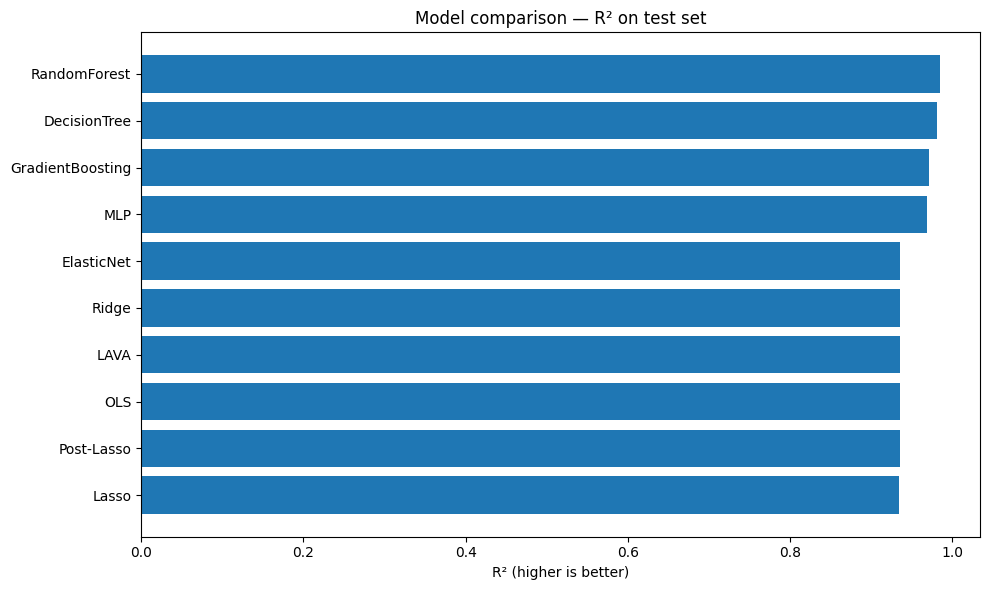

In [ ]:
# R² plot
plt.figure(figsize=(10,6))
plt.barh(comp_df['Model'], comp_df['R2'])
plt.xlabel('R² (higher is better)')
plt.title('Model comparison — R² on test set')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('outputs/r2_comparison.png', dpi=150)
plt.show()


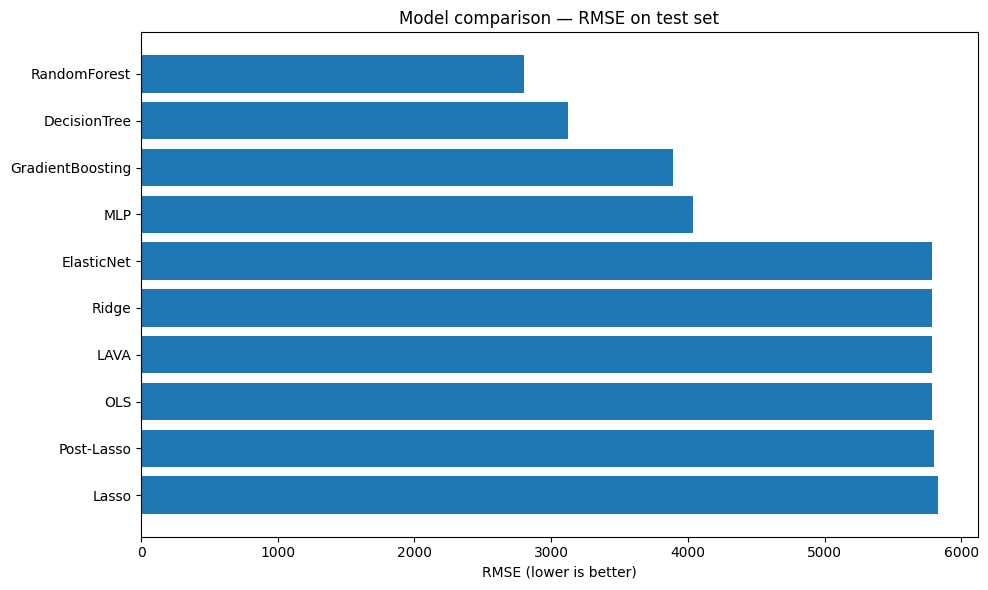

In [ ]:
# RMSE plot
plt.figure(figsize=(10,6))
plt.barh(comp_df['Model'], comp_df['RMSE'])
plt.xlabel('RMSE (lower is better)')
plt.title('Model comparison — RMSE on test set')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('outputs/rmse_comparison.png', dpi=150)
plt.show()

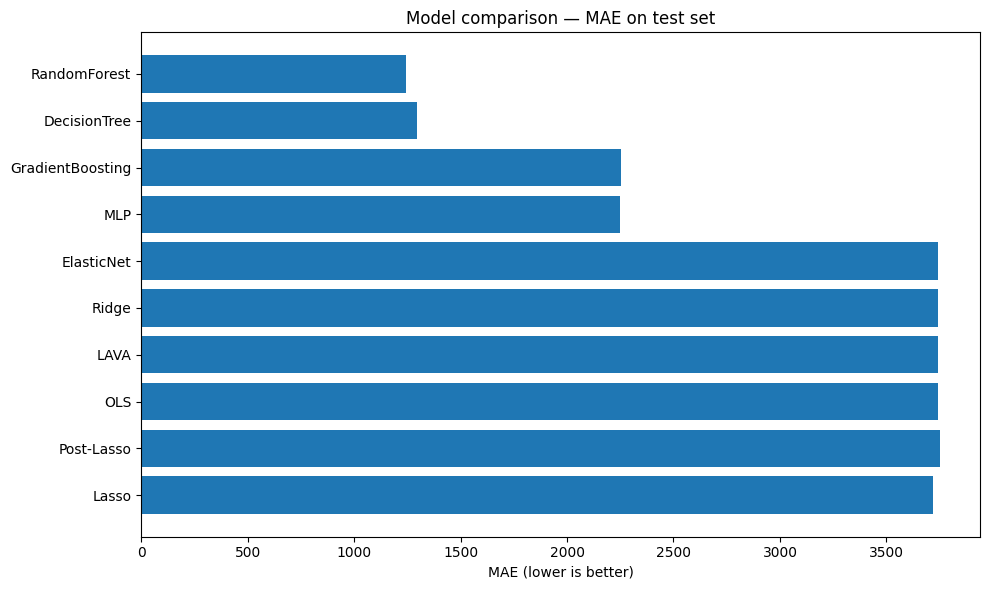

In [ ]:
# MAE plot
plt.figure(figsize=(10,6))
plt.barh(comp_df['Model'], comp_df['MAE'])
plt.xlabel('MAE (lower is better)')
plt.title('Model comparison — MAE on test set')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('outputs/mae_comparison.png', dpi=150)
plt.show()


In [ ]:
# Print top-3
print('\nTop-3 models by RMSE:', comp_df.iloc[:3]['Model'].tolist())




Top-3 models by RMSE: ['RandomForest', 'DecisionTree', 'GradientBoosting']
